# Messed Up Models: Fiddling with Feature Selection, Two Ways

Linear regression models can quickly suffocate an unsuspecting data scientist with the loving embrace of dimensionality. You might start with an already large number of features and/or decide you need to engineer more. You might say 'screw it' and throw it all into Scikit-learn's PolynomialRegression tool--it's criminally easy to make features, especially complex features like polynomials and interation terms. But features such as these, especially if you use all of them, are going to overfit a ton. Sure, packing a model with as many features as there are lines of code will give you a great $R^2$, but that model's going to fit unseen data like a $2 suit. And having a generalizable model with predictive value for unseen data is frequently the point of creating a linear regression in the first place!

So, it helps to do some feature selection. Indeed, one of the most important tasks is to filter out all but the most essential features for describing the data. This will not only help cut down on your model's overfit, but also make clearer to a non-technical audience which features actually matter.

As you might expect, there are a number of tools to vaguely bang your model into shape, and in this post, we'll be taking a look at two different methods, courtesy of the consummate Scikit-learn:
1. Recursive feature elimination
2. Lasso regression, which uses regularization to bring coefficients to 0, eliminating them

To hammer home the relevance and utility of these functions, I'll quickly run through the data cleaning and processing steps of a recent project I worked on. This should hopefully demonstrate where these functions can be useful in a real-world project. Then, I'll give a brief introduction and a typical set up and execution, including a relevant hyperparameter for each. I'll close with a short discussion of benefits and drawbacks for each function.

## Dataset: King County Housing Sales

This post will use much of the work I had done recently on a project that used data collected on house sales in King County, Washington. It includes homes sold between May 2014 and May 2015, gathered from King County GIS Open Data. My team wanted to build a model that would be able to predict the price of a house sale given a number of available features, such as square-footage, floors, bathrooms, grade, condition, etc. The features are listed a little ways below. 

## Libraries: Scikit-learn, with supporting cast

As you can see below, this is mostly Scikit-learn functions, with some statsmodels stuff thrown in for visualization down the line.

In [76]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

## Exploring the data & A bit of tidying

Apologies in advance, the data started out not terribly clean (as per usual with a data science project), so there is some cleaning and processing that needs to be done. Bear with me. Also feel free to skip towards the end if you want to get to the meat of this tutorial.

In [77]:
data = pd.read_csv('data/kc_house_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

As you can see, we have quite a few relevant features to use, and some not so relevant.

In [78]:
# dropping columns with null values for ease
data.drop(columns=['waterfront','view','yr_renovated'], inplace=True)

In [79]:
# dropping duplicates from the data set based on their id value.
data.drop_duplicates(subset='id', inplace=True)

In [80]:
# '?' is a strange value for basement size, we'll make that 0
data.loc[data['sqft_basement'] == '?','sqft_basement'] = 0.0
# orginally this data was stored as text (object), 
# we transform the data type to float to use later for anaylsis
# check to ensure the "?" is now 0.0
data['sqft_basement'] = data['sqft_basement'].map(float)

In [81]:
# one datapoint has 33 bedrooms, which is bananas. We'll drop it
data = data[data['bedrooms'] != 33]

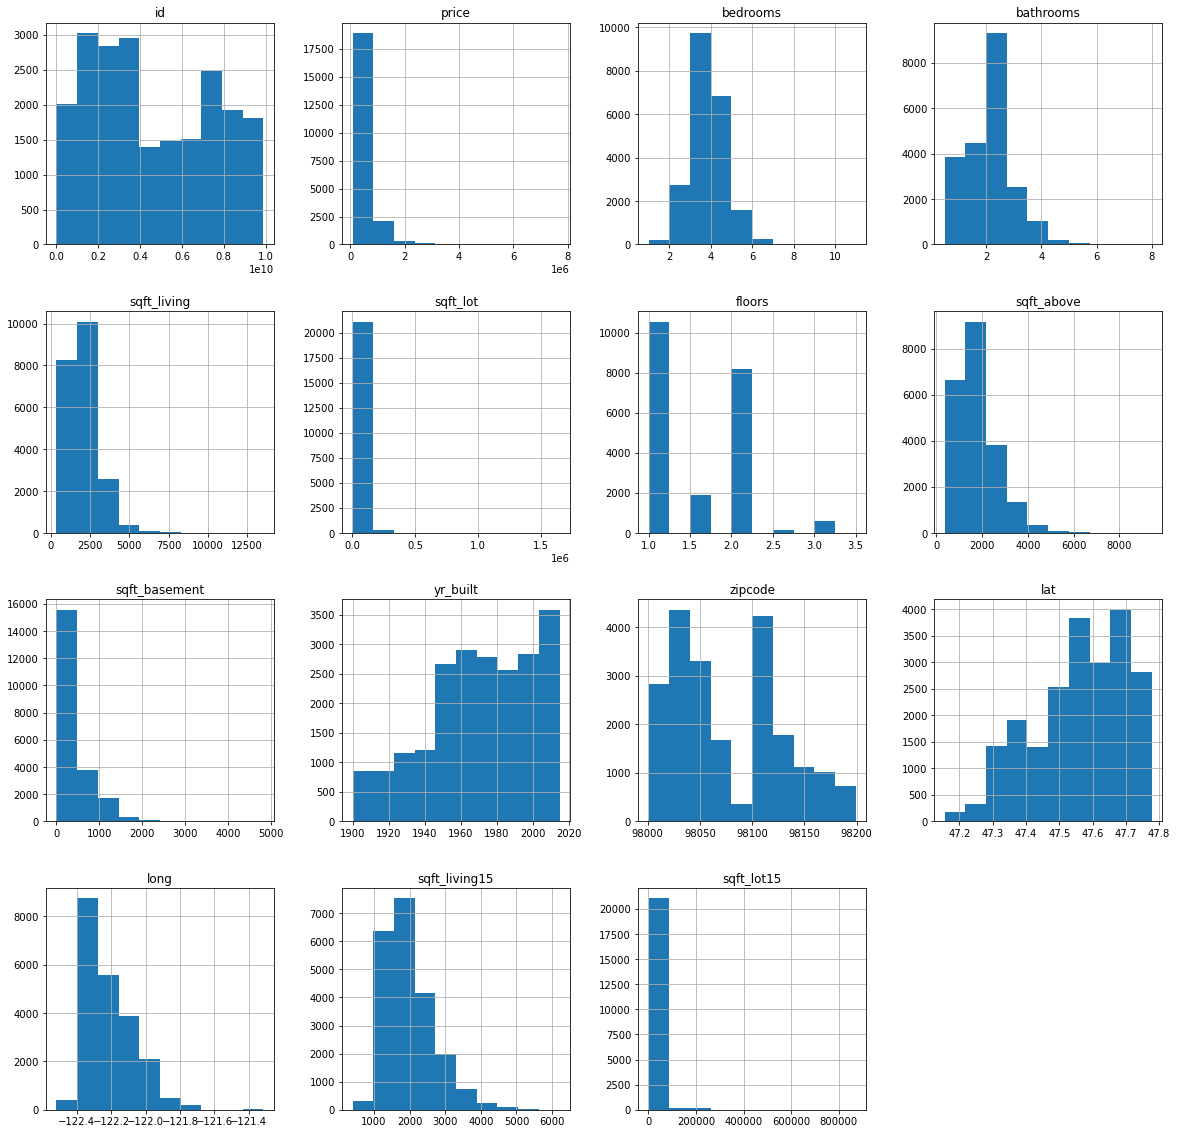

In [82]:
# exploring the distribution of the features
data.hist(figsize=(20,20));

Some of these features ('price','sqft_living','sqft_lot','sqft_above','sqft_basement', 'sqft_living15','sqft_lot15') look like they could use some log processing. Running a log transformation will help normalize the data for better regression analysis down the line.

In [83]:
#running the log transformation. creates a new data frame.
datalog = pd.DataFrame()
log_cols = ['id','price','sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15',
           'sqft_lot15']
for col in log_cols:
    if col == 'id':
        datalog[col] = data[col]
        continue
    datalog[f'{col}_log'] = data[col].map(lambda x: np.log(x))
    
#merges the original and new dataframe
data = pd.merge(data,datalog,on='id')

## Quick Note

Because some features (like the target, 'price') is so skewed, we'll use log transformations of these variables, since it will be more normally distributed and thus will follow the assumptions of linear regression a bit better (residuals will be more normal as well). We're comparing RMSE and MAE for different methods of feature selection at the end of all this so a target variable transformation isn't really important to understand. I just wanted to mention it so you wouldn't get too confused seeing something different.

We'll also trim our big dataset to include only the log-transformed features and a few others.

In [84]:
#reducing our features to consider
rel_cols = ['price_log', 'grade', 'condition', 'sqft_living_log',
            'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 
            'bedrooms', 'bathrooms', 'floors', 'yr_built', 'lat', 'long', 'sqft_living15_log',
            'sqft_lot15_log']
data = data[rel_cols]

### Transforming Categorical Data
#### 'Grade' to 4 categories: Low, Average, Above Average, and Excellent

In [85]:
# Lows including 3 Poor, 5 Fair and 6 Low Average
data['grade'].replace('3 Poor','Low_Grade', inplace=True)
data['grade'].replace('5 Fair','Low_Grade', inplace=True)
data['grade'].replace('4 Low','Low_Grade', inplace=True)
data['grade'].replace('6 Low Average','Low_Grade', inplace=True)

# Average including 7 Average 
data['grade'].replace('7 Average','Average_Grade', inplace=True)

# Average Above including 8 Good,9 Better
data['grade'].replace('8 Good','Above_Average_Grade', inplace=True)
data['grade'].replace('9 Better','Above_Average_Grade', inplace=True)

# Excellent including 10 Very Good, 11 Excellent,12 Luxury and 13 Mansion
data['grade'].replace('10 Very Good','Excellent_Grade', inplace=True)
data['grade'].replace('11 Excellent','Excellent_Grade', inplace=True)
data['grade'].replace('12 Luxury','Excellent_Grade', inplace=True)
data['grade'].replace('13 Mansion','Excellent_Grade', inplace=True)

#### 'Condition' to only 2 categories: Low-Average, and Good

In [86]:
# Low-Average including Poor, Fair, Average
data['condition'].replace('Poor','Low-Average_Condition', inplace=True)
data['condition'].replace('Fair','Low-Average_Condition', inplace=True)
data['condition'].replace('Average','Low-Average_Condition', inplace=True)

# Good including Good and Very Good
data['condition'].replace('Good','Good_Condition', inplace=True)
data['condition'].replace('Very Good','Good_Condition', inplace=True)

#data is better distribued when grouped
data['condition'].value_counts(normalize=True)

Low-Average_Condition    0.657827
Good_Condition           0.342173
Name: condition, dtype: float64

### One-Hot Encoding the categorical data
Breaking out our categorical features (Condition and Grade) into individual columns using Scikit-learn's OneHotEncoder. We'll drop the 'Low-Average Condition' and 'Average Grade' column to avoid multicollinearity issues

In [87]:
cond = data[["condition"]]
ohe = OneHotEncoder(categories="auto", handle_unknown="error", sparse=False)
ohe.fit(cond)
cond_encod = ohe.transform(cond)
cond_encod = pd.DataFrame(
    # Pass in NumPy array
    cond_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
cond_encod.drop(columns='Low-Average_Condition', inplace=True)

In [88]:
grade = data[["grade"]]
ohe = OneHotEncoder(categories="auto",handle_unknown="ignore", sparse=False)
ohe.fit(grade)
grade_encod = ohe.transform(grade)
grade_encod = pd.DataFrame(
    # Pass in NumPy array
    grade_encod,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index= data.index
)
grade_encod.drop(columns='Average_Grade', inplace=True)

In [89]:
#drops the orginal columns because the data we need is now split into columns
data = pd.concat([data, cond_encod, grade_encod], axis=1)\
        .drop(columns=['condition','grade'])

### Changing sqft_basement to a binomial variable "has_basement"

In [90]:
# replace sqft_basement with has_basement: True (1) / False (0)
data['sqft_basement_log'] = data['sqft_basement_log'].map(lambda x: 1 if x > 0 else 0)
data.rename(columns={'sqft_basement_log':'has_basement'}, inplace=True)

In [91]:
#an organized series showing the correlations to price
datacorr = data.corr().sort_values('price_log',ascending=False)['price_log']
datacorr = datacorr.drop(index=['price_log'])
datacorr

sqft_living_log        0.674862
sqft_living15_log      0.606890
sqft_above_log         0.586223
bathrooms              0.551553
Excellent_Grade        0.480448
lat                    0.447761
bedrooms               0.351601
floors                 0.310337
Above_Average_Grade    0.301334
has_basement           0.207999
sqft_lot_log           0.138580
sqft_lot15_log         0.124129
yr_built               0.079685
long                   0.049770
Good_Condition        -0.003968
Low_Grade             -0.348078
Name: price_log, dtype: float64

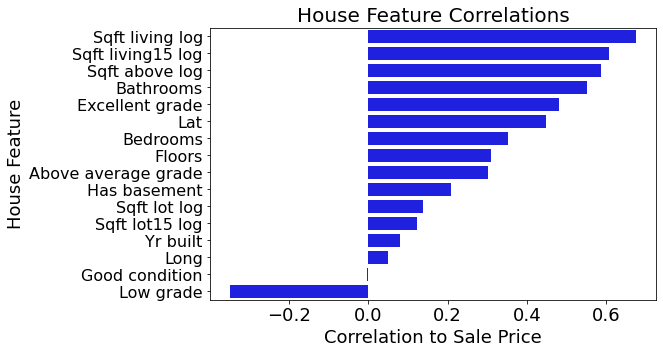

In [92]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=datacorr.values, y=datacorr.index, orient='h', color='b')
ylabels = [item.capitalize() for item in datacorr.index]
ylabels = [item.split('_') for item in ylabels]
ylabels = [' '.join(item) for item in ylabels]
ax.set_yticklabels(ylabels, size=16)
ax.tick_params(axis='x', which='major', labelsize=18)
ax.set_xlabel('Correlation to Sale Price', size=18)
ax.set_ylabel('House Feature', size=18)
ax.set_title('House Feature Correlations', size=20)
plt.savefig("images/correlations.png");

In [93]:
# examining multicollinearity
# analyzing the highly correlated pairs
datafeat = data.drop(columns=['price_log'])
dtfc = datafeat.corr().abs().stack().reset_index().sort_values(0, ascending=False)

dtfc['col_pairs'] = list(zip(dtfc.level_0,dtfc.level_1))
dtfc['same'] = dtfc['col_pairs'].map(lambda x: (x[0] in x[1]) or (x[1] in x[0]))
dtfc['col_pairs'] = dtfc['col_pairs'].map(lambda x:sorted(list(x)))
dtfc.set_index(['col_pairs'],inplace=True)
dtfc = dtfc[dtfc['same'] == False]
dtfc.drop(columns=['level_0','level_1','same'],inplace=True)
dtfc.columns = ['C']
dtfc.drop_duplicates(inplace=True)
dtfc.head(20)

,C
col_pairs,
"[sqft_lot15_log, sqft_lot_log]",0.918610
"[sqft_above_log, sqft_living_log]",0.865069
"[bathrooms, sqft_living_log]",0.761852
"[sqft_living15_log, sqft_living_log]",0.747163
"[sqft_above_log, sqft_living15_log]",0.713572
"[bathrooms, sqft_above_log]",0.695399
"[bedrooms, sqft_living_log]",0.638490
"[bathrooms, sqft_living15_log]",0.571274
"[floors, sqft_above_log]",0.546464


## Preprocessing

Now that we have all our features somewhat clean, let's preprocess. First we'll do the standard train-test split (saving the test for validation), then make some polynomial and interaction features. Finally, we'll scale everything so the Lasso regression can work properly.

### Train-Test Split the data

In [94]:
#X will all of the features of the data set to analyze. "price_log" will be the target variable.
X = data.drop(columns='price_log')

X_train, X_test, y_train, y_test = \
train_test_split(X, data['price_log'], test_size=0.33, random_state=42)

### Feature Engineering

There are a few variables to work with, and as shown above, there are some multicollinearity issues. Making some polynomial features might be a way around this, while also retaining as much original information as we can (i.e. not simply removing whole columns).

We're going to do this shotgun-style and use Scikit-learn's PolynomialFeatures to get a whole mess of em. We'll go a little crazy with it and go to degree = 3.

In [95]:
poly = PolynomialFeatures(degree=3)
poly.fit(X_train)
polycols = ['*'.join(name.split(" ")) for name\
            in poly.get_feature_names(X_train.columns)] # make it look nice
X_train_poly = pd.DataFrame(poly.transform(X_train), columns=polycols,
                           index=X_train.index) # our monster features
X_test_poly = pd.DataFrame(poly.transform(X_test), columns=polycols,
                           index=X_test.index)

# don't need constant term, since added later automatically
X_train_poly.drop(columns='1', inplace=True)
X_test_poly.drop(columns='1', inplace=True)

In [96]:
# here's Sklearn's Standard Scaler to scale all of our data to the same scale

scaler = StandardScaler()
scaler.fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_train_poly_scaled = pd.DataFrame(X_train_poly_scaled, columns=X_train_poly.columns,
                              index=X_train_poly.index)
X_test_poly_scaled = scaler.transform(X_test_poly)
X_test_poly_scaled = pd.DataFrame(X_test_poly_scaled, columns=X_test_poly.columns,
                              index=X_test_poly.index)

## Finally: Some Models

We have our training and testing data PolynomialFeature'd up and scaled now -- let's see how the two feature selection methods work out. It's worth noting that typically, I would use cross-validation to evaluate the models, only saving the test data for the final evaluation at the end. However, for simplicity's sake, we'll just skip that.

First, some evaluation functions. 
- `evaluate` will give us the $R^2$ score, RMSE, and MAE for training and test data, so we can evaluate how the methods do with this mess of available features
- `smols` will give us a ordinary least squares object that we can get a summary of, to see the coefficients
- `linpreds` will give us predictions for the training and test data, to feed into `evaluate`

In [97]:
# function to evaluate the models and their predicted sale prices vs. the actual sale prices
def evaluate(y_tr, y_te, y_tr_pr, y_te_pr, log=True):
    '''
    Evaluates the error between the model predictions and the real values for both
    training and test sets.
    
    Arguments:
    y_tr - array-like
        Actual values for output variable, for the training set
    y_tr_pr - array-like
        Predicted values for output variable, for the training set
    y_te - array-like
        Actual values for output variable, for the test set
    y_te_pr - array-like
        Predicted values for output variable, for the test set
    log=True
        If true, 
    Returns:
    R2 scores for Train and Test sets
    RMSE for Train and Test sets
    MAE for Train and Test sets
    '''
    if log == True:
        y_tr = np.exp(y_tr)
        y_te = np.exp(y_te)
        y_tr_pr = np.exp(y_tr_pr)
        y_te_pr = np.exp(y_te_pr)
        
    # residuals
    train_res = y_tr - y_tr_pr
    test_res = y_te - y_te_pr
    
    print(f'Train R2 score: {r2_score(y_tr, y_tr_pr)} ')
    print(f'Test R2 score: {r2_score(y_te, y_te_pr)} ')
    print('<><><><><>')
    print(f'Train RMSE: ${mean_squared_error(y_tr, y_tr_pr, squared=False):,.2f} ')
    print(f'Test RMSE: ${mean_squared_error(y_te, y_te_pr, squared=False):,.2f} ')
    print('<><><><><>')
    print(f'Train MAE: ${mean_absolute_error(y_tr, y_tr_pr):,.2f} ')
    print(f'Test MAE: ${mean_absolute_error(y_te, y_te_pr):,.2f} ')
    

    
    # scatter plot of residuals
    print("\nScatter of residuals:")
    plt.scatter(y_tr_pr, train_res, label='Train')
    plt.scatter(y_te_pr, test_res, label='Test')
    plt.axhline(y=0, color='purple', label='0')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual Price")
    plt.legend()
    plt.show()
    
    # QQ plot of residuals
    print("QQ Plot of residuals:")
    fig, ax = plt.subplots()
    sm.qqplot(train_res, ax=ax, marker='.', color='r', label='Train', alpha=0.3, line='s')
    sm.qqplot(test_res, ax=ax,  marker='.', color='g', label='Test', alpha=0.3)
    plt.legend()

In [98]:
def smols(X,y,cols=None):
    '''
    Uses Linear Regression to find a best fit given desired features.
    
    Arguments:
    X - dataframe
        Input features and values
    y - array-like
        Output values
    cols=None - list
        List of features to be included from the X dataframe
        if cols == '*', run model with all columns in X.         
    Returns: OLS model. Use smols().summary() to view summary
    '''
    if cols == '*':
        return sm.OLS(endog=y, exog=sm.add_constant(X)).fit()
    else:
        Xcol = X[cols]
        return sm.OLS(endog=y, exog=sm.add_constant(Xcol)).fit()

In [99]:
def linpreds(X_tr, y_tr, X_te):
    '''
    Uses Linear Regression to generate output predictions given training and test inputs.
    Arguments:
    X_tr - dataframe
        Input variables and values for the training set
    y_tr - array-like
        Actual values for output variable, for the training set
    X_te - dataframe
        Input variables and values for the test set
    Returns:
    Output (y) prediction arrays:
        train, test
    '''
    lr = LinearRegression()
    lr.fit(X_tr, y_tr)
    return lr.predict(X_tr), lr.predict(X_te)

### Baseline Understanding

The simplest model will predict the average price for all homes regardless of their features. This is the baseline model we use to compare all future models against.

In [100]:
train_target_mean = y_train.mean()
baseline_train_pred = [train_target_mean] * len(y_train)
baseline_test_pred = [train_target_mean] * len(y_test)

Train R2 score: -0.04156839582496619 
Test R2 score: -0.04468446482794208 
<><><><><>
Train RMSE: $378,961.72 
Test RMSE: $368,922.27 
<><><><><>
Train MAE: $221,094.25 
Test MAE: $225,202.03 

Scatter of residuals:


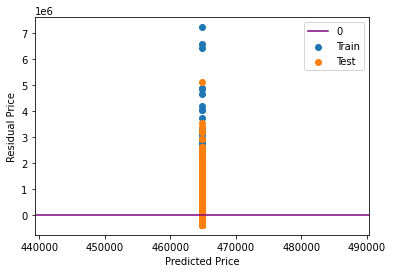

QQ Plot of residuals:


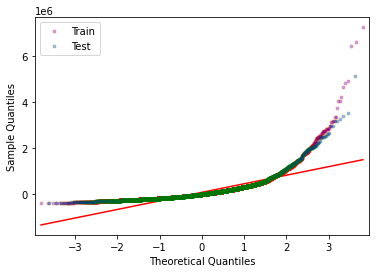

In [101]:
evaluate(y_train, y_test, baseline_train_pred, baseline_test_pred)

Pretty awful model, as expected. But we'll see how we do moving forward.

### Top Correlator Only Model

As an additional point of comparison, let's see how a model does using only the top correlated feature, `sqft_living_log`.

In [102]:
smols(X_train_poly_scaled,y_train,cols=['sqft_living_log']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.179e+04
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:41:47   Log-Likelihood:                -6786.5
No. Observations:               14350   AIC:                         1.358e+04
Df Residuals:                   14348   BIC:                         1.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.0494      0.003   4025.645      0.000      13.043      13.056
sqft_living_log     0.3520      0.003    108.601      0.000       0.346       0.358
==============================================================================
Omnibus:                       76.585   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.661
Skew:                           0.147   Prob(JB):                     1.67e-16
Kurtosis:                       2.812   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train R2 score: 0.41417500685621833 
Test R2 score: 0.4256008323060684 
<><><><><>
Train RMSE: $284,207.41 
Test RMSE: $273,557.86 
<><><><><>
Train MAE: $168,860.59 
Test MAE: $169,163.47 

Scatter of residuals:


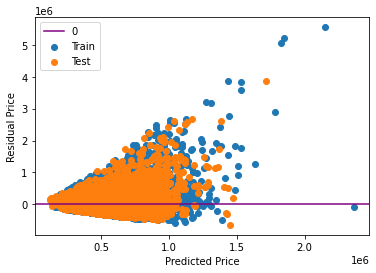

QQ Plot of residuals:


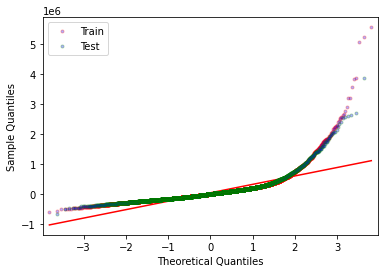

In [103]:
evaluate(y_train, y_test,
         *linpreds(X_train[['sqft_living_log']], y_train, X_test[['sqft_living_log']]))

Judging by the RMSE, it's doing better than the baseline, but not well enough to write home about. An improvement of ~100k is still pretty good though. Let's see if what happens when we use all the polynomial features we generated...

### Kitchen Sink Model

On the other end of the spectrum, let's throw in all the features we made, for kicks. As of writing this, I haven't run it yet, but I bet it's going to be a mess...

Update: yup, it's a frickin' mess.

In [104]:
smols(X_train_poly_scaled, y_train, cols='*').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     103.7
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:43:08   Log-Likelihood:                 3313.7
No. Observations:               14350   AIC:                            -4945.
Df Residuals:                   13509   BIC:                             1422.
Df Model:                         840                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                    13.0494      0.002   7896.382      0.000      13.046      13.053
sqft_living_log                                       -8582.9459   1.09e+04     -0.789      0.430   -2.99e+04    1.27e+04
sqft_lot_log                                          -2591.0411   4306.037     -0.602      0.547    -1.1e+04    5849.392
sqft_above_log                                         -881.3012   1.09e+04     -0.081      0.936   -2.22e+04    2.05e+04
has_basement                                           1724.6209   1577.735      1.093      0.274   -1367.959    4817.201
bedrooms                                               -297.8052   2448.323     -0.122      0.903   -5096.861    4501.250
bathrooms                                              1358.0409   3382.724      0.401      0.688   -5272.570    7988.652
floors                                                 5564.5823   2544.665      2.187      0.029     576.683    1.06e+04
yr_built                                               -343.5654   2950.333     -0.116      0.907   -6126.630    5439.499
lat                                                   -3.826e+04   2259.236    -16.936      0.000   -4.27e+04   -3.38e+04
long                                                   5529.3790   2943.187      1.879      0.060    -239.678    1.13e+04
sqft_living15_log                                      3868.9232   2939.030      1.316      0.188   -1891.986    9629.832
sqft_lot15_log                                         9677.5117   4271.485      2.266      0.023    1304.805    1.81e+04
Good_Condition                                          -20.0183    650.663     -0.031      0.975   -1295.409    1255.373
Above_Average_Grade                                    -418.1021    812.728     -0.514      0.607   -2011.163    1174.959
Excellent_Grade                                        3396.0088   1059.947      3.204      0.001    1318.365    5473.653
Low_Grade                                              2392.3109    608.671      3.930      0.000    1199.232    3585.390
sqft_living_log^2                                     -1032.8647   1254.090     -0.824      0.410   -3491.056    1425.327
sqft_living_log*sqft_lot_log                          -2075.7154    716.065     -2.899      0.004   -3479.303    -672.128
sqft_living_log*sqft_above_log                         1241.3578   2186.185      0.568      0.570   -3043.870    5526.586
sqft_living_log*has_basement                            -34.9968    191.529     -0.183      0.855    -410.421     340.427
sqft_living_log*bedrooms                                552.3887    294.157      1.878      0.060     -24.200    1128.977
sqft_living_log*bathrooms        

Train R2 score: 0.8596637612712984 
Test R2 score: 0.7776950443871566 
<><><><><>
Train RMSE: $139,102.96 
Test RMSE: $170,183.27 
<><><><><>
Train MAE: $79,449.88 
Test MAE: $91,174.08 

Scatter of residuals:


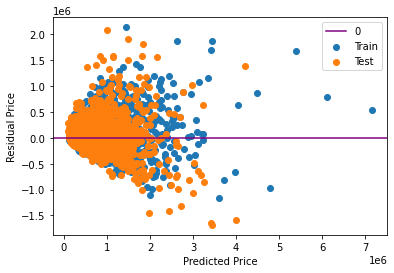

QQ Plot of residuals:


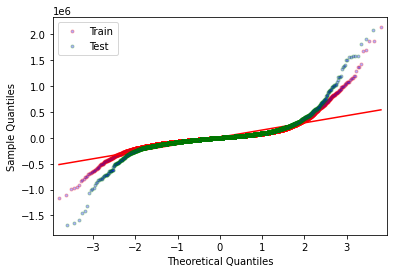

In [105]:
evaluate(y_train, y_test, *linpreds(X_train_poly_scaled, y_train, X_test_poly_scaled))

The fit itself ain't half bad--as expected for the absurd number of polynomial features we threw into it. But the model does considerably better for the training better than for the test data (~20% difference). This would indicate some overfitting issues, for sure. And as you can see in the `smols` output, many coefficients are very small, and many with significantly high p-values. This would all suggest there are a good number of coefficients we can cut. Let's dig into the point of this entire post: feature selection.

## Feature Selection: aka The Point of this Entire Post
##### (Thank you for staying with me up to here)

We now have our data cleaned, our train/test splits preprocessed, and we have some benchmarks to compare against with the feature selection methods.

The task we have now is, at its core, to programmatically ascertain the most important features of the mountain we generated earlier. Doing this allows your model to have the truly important bits, without picking up so much of the noise in the training data. This, in turn, allows your model to be more generalizable and perform better with data it hasn't seen before.

We'll use RMSE as our benchmark. We want to see that RMSE is reduced enough (limiting bias), but not that the training data has a significantly lower RMSE than the test data (indicating higher variance and over-fitting). If these two requirements are true, we can feel somewhat safe that our model is trustworthy for unseen data.

### Method 1: Recursive Feature Elimination

This is a handy function [(documentation here)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) that takes a model and number of features as parameters. It'll go through the available features and iteratively remove them, based on worst performers in any attribute you wish to set. In this case, we'll stick with the default for ease, which is coefficient of features (smallest coefficient features are removed). Let's choose a handful of numbers of features and get the resulting RMSEs for the train and test, to see how this does as we vary the number of included features. I'll graph the RMSEs down below. Reminder: we have a whopping 968 features available.

In [128]:
nums = [300, 200, 150, 100, 50, 25, 20, 10, 5] # number of features
linreg = LinearRegression() # instantiate linear model

rfe_train_rmse = []
rfe_test_rmse = []
for num in nums: # loop through number of features
    rfe = RFE(linreg, n_features_to_select=num, step=25) # remove 25 worst features at a time
    rfe.fit(X_train_poly_scaled, y_train) # fit
    rtrpred = rfe.predict(X_train_poly_scaled) # predict training y values
    rtepred = rfe.predict(X_test_poly_scaled) # predict testing y values
    rfe_train_rmse.append(mean_squared_error(np.exp(y_train),
                                             np.exp(rtrpred), squared=False)) # rmse for training
    rfe_test_rmse.append(mean_squared_error(np.exp(y_test),
                                            np.exp(rtepred), squared=False)) # rmse for testing

### Method 2: Lasso Regression

This method [(documentation here)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso) uses regularization to reduce the number of features. It penalizes a function for having high and/or too many coefficients, and will solve for coefficient values partly by bringing some terms to 0. This function includes a hyperparamter, `alpha`, which determines the amount of regularization involved. We'll check out a range of magnitudes of `alpha`, from 10 to 0.0000001 (1e-7), corresponding to decreasing regularization strength. Again, we'll get the resulting RMSEs for train and test, and graph below.

In [141]:
alphas = [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7] # number of alphas

lasso_train_rmse = []
lasso_test_rmse = []
for alpha in alphas: # loop through alphas
    lasso = Lasso(alpha=alpha) # instantiate Lasso for each alpha
    lasso.fit(X_train_poly_scaled, y_train) # fit
    ltrpred = lasso.predict(X_train_poly_scaled) # predict training y values
    ltepred = lasso.predict(X_test_poly_scaled) # predict testing y values
    lasso_train_rmse.append(mean_squared_error(np.exp(y_train), 
                                               np.exp(ltrpred), squared=False)) # rmse for training
    lasso_test_rmse.append(mean_squared_error(np.exp(y_test),
                                              np.exp(ltepred), squared=False)) # rmse for testing

## Results

As a reminder, I have the resulting initial RMSEs from above placed here as a point of comparison for the following graphs:

Baseline:
- Train RMSE: \$378,961.72 
- Test RMSE: \$368,922.27

Top Correlator Only (`sqft_living_log`):
- Train RMSE: \$284,207.41 
- Test RMSE: \$273,557.86

Kitchen Sink Model:
- Train RMSE: \$139,102.96 
- Test RMSE: \$170,183.27

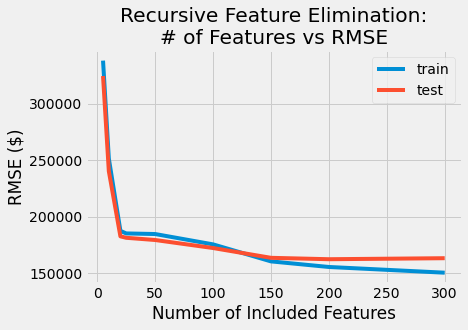

In [142]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.title('Recursive Feature Elimination:\n# of Features vs RMSE')
ax.set_xlabel('Number of Included Features')
ax.set_ylabel('RMSE ($)')
ax.plot(nums, rfe_train_rmse, label='train')
ax.plot(nums, rfe_test_rmse, label='test')
plt.legend();

In [149]:
# test RMSE values for RFE
dict(zip(nums, rfe_test_rmse))

{300: 163226.1209247706,
 200: 162327.3958798999,
 150: 163561.65657735604,
 100: 172228.44477506538,
 50: 179321.99371104912,
 25: 181287.25651190692,
 20: 182580.9542072269,
 10: 240234.43394588708,
 5: 324390.94620213495}

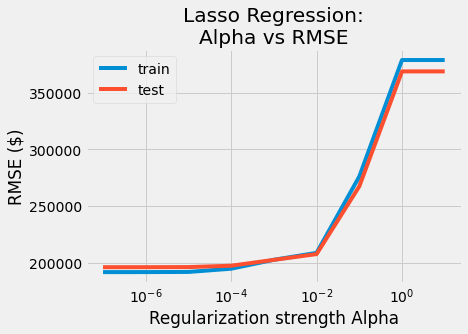

In [143]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.xscale('log')
plt.title('Lasso Regression:\nAlpha vs RMSE')
ax.set_xlabel('Regularization strength Alpha')
ax.set_ylabel('RMSE ($)')
ax.plot(alphas, lasso_train_rmse, label='train')
ax.plot(alphas, lasso_test_rmse, label='test')
plt.legend();

## Summary

There are a few conclusions we can draw from these charts. You might notice that for most hyperparameters we set, the test RMSE doesn't do much better than the Kitchen Sink Model. This is acceptable because, as I mentioned, with fewer features you gain a level of trustworthiness that your model isn't too specific to the training data and will handle unseen data well. The only exception to that is for 150, 200, and 300 features selected with RFE, which perform about \$7-8k better. This is fantastic, since we're both getting rid of unnecessary features and minimizing error. I would also note though that with 300 features you start getting into overfitting territory though since the train RMSE, keeps decreasing and the test RMSE is beginning to slowly creep up. 

Given we've found a sweet spot of features with the first method, if we wanted more specificity, the next step would be to hone in on the number of features and maybe play around with the step size. But before you completely write off Lasso, there is also one more tradeoff worth considering -- computational cost. Running those two cells had a large difference in the amount of time it took to run. RFE took roughly 20 minutes at those settings, and Lasso only around 5 minutes. Definitely something to consider moving forward. 

Lastly, it's worth mentioning that it only worked out that RFE was the better method in this particular case with this particular data set and procedure. Other datasets and styles of processing will probably yield vastly different results. Therefore, it's important to remember that many feature selection methods exist. These are two common ones, and there are still others that may or may not work better.

Thank you for reading, hope this helps your Curse of Dimensionality!